<a href="https://colab.research.google.com/github/bernieee/SIRIUS/blob/master/AI_for_Med_image_analysis/Practicum1_working_with_CT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This is the second practical task of Sirius summer school "Applying AI for Med image analysis". 
Practical tasks take form of jupyter notebook with example code in the begging and some tasks in the end. Please, provide your solution in form of python code. Read hints, google a lot, don't hesitate to ask us directyl and most importatly - 
<span style="color:blue">have fun</span>.


**Topic**: 3D data 

**To submit**: New version of the notebook, with your code. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#let's install pydicom, which is a library to operate dicom files and their content
!pip install pydicom 

     |████████████████████████████████| 35.5MB 107kB/s 


In [3]:
#important imports
import pydicom 
from pydicom.pixel_data_handlers.util import *
import matplotlib.pyplot as plt

In [4]:
path = "/content/drive/My Drive/Sirius 2020/"

#### CT consists of multiple slice. Each slice is usually stored in separate DICOM file with special meta tag, which allows to reccreate their order. 

Slice 1 location -939.44
Slice 2 location -932.69


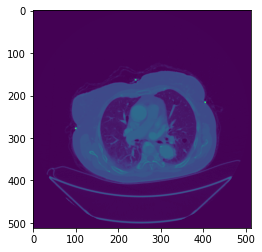

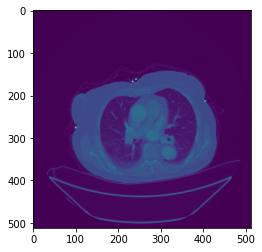

In [ ]:
slice1 = pydicom.read_file(path + "data/aorta/1/I10.dicom")
slice2 = pydicom.read_file(path + "data/aorta/1/I100")
print("Slice 1 location {}".format(slice1.SliceLocation))
print("Slice 2 location {}".format(slice2.SliceLocation))
plt.imshow(slice1.pixel_array)
plt.show()
plt.imshow(slice2.pixel_array)

Let's create function, which takes directory as an input and produced ordered sequence of slices. 

In [5]:
def load_scan(path, filter_slices=False):
    """
    Loads all slices from directory and sorts them according to position
    """
    import os
    files = os.listdir(path)
    slices = [pydicom.read_file(os.path.join(path,s)) for s in files]
    if filter_slices:
        slices = filter_bad_slices(slices)
    slices.sort(key=lambda x: float(x.SliceLocation))
    return slices

def get_pixels_hu(slices):
    """
    Convert dicom files to Hu, acording to DICOM defined scheme 
    (more info https://dicom.innolitics.com/ciods/ct-image/ct-image/00281052)
    """
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)

    for slice_number in range(len(slices)):

        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope

        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)

        image[slice_number] += np.int16(intercept)

    return np.array(image, dtype=np.int16)

### This might take some time to load

In [6]:
scan = load_scan(path + "data/aorta/1")
array_3d = get_pixels_hu(scan)
print("Resulting array shape is {}".format(array_3d.shape))

Resulting array shape is (1718, 512, 512)


Let's check value distribution and compare it with Hounsfield scale 
![Hnsfield](https://www.researchgate.net/publication/327863426/figure/tbl1/AS:674762674147338@1537887366780/Hounsfield-scale-table.png)

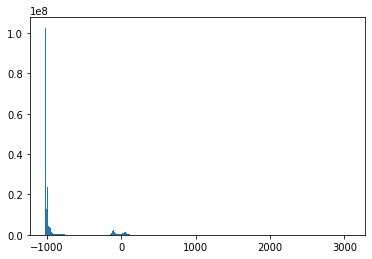

Most common element is -1024.0


In [ ]:
hist = plt.hist(array_3d.ravel(),bins=1000) #see https://matplotlib.org/3.2.2/api/_as_gen/matplotlib.pyplot.hist.html for details of this trick
plt.show()
print("Most common element is {}".format(hist[1][np.argmax(hist[0])]))

## - But there is no -1024 on Honsfield scale?!
### - Actually modern CT devices diferentiate between "inside" and "outside" of patient, hence --1024 is value for "outside air", which obviously is most frequent substance. 
Let's cut "outside" air out

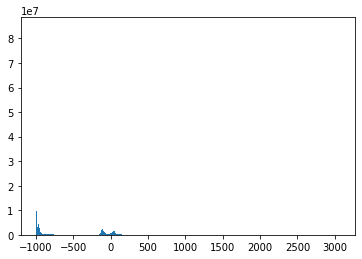

Most common element is -1000.0


In [ ]:
hist = plt.hist(array_3d[array_3d>=-1000].ravel(),bins=1000) #see https://matplotlib.org/3.2.2/api/_as_gen/matplotlib.pyplot.hist.html for details of this trick
plt.show()
print("Most common element is {}".format(hist[1][np.argmax(hist[0])]))

Let's create interactive plot of CT scan, which allows to scroll through slices. 

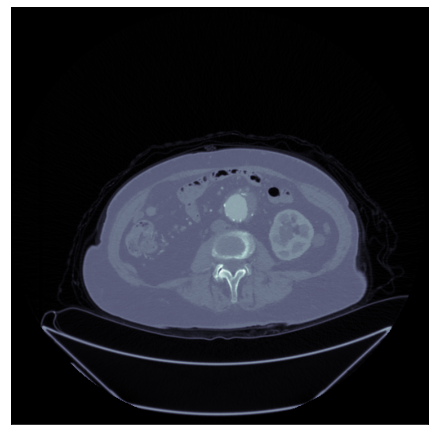

In [7]:
from ipywidgets.widgets import interact, IntSlider, fixed

def single_2d_plot(img, mask=None, aspect=1.0, figsize=None):
    if figsize is None:
        figsize = (0.015 * img.shape[1], 0.015 * img.shape[0])
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.imshow(img, cmap=plt.cm.bone)
    ax.set_aspect(aspect)

    if mask is not None:
        mask = np.ma.masked_where(mask == 0, mask)
        plt.imshow(mask, alpha=0.4, cmap='viridis')

    plt.plot()

# Interactive plot
interact(lambda z: single_2d_plot(array_3d[z]), 
      z=IntSlider(min=0, max=array_3d.shape[0]-1, value=581, continious_update=False), 
)

## **Task 1:**
- Theory: Thresholding is simple technique to filter unwanted details from image. It could be used it visualize high density matter on CT scan. 
- Given: CT scan lodaded into array_3d variable 
- Do: Apply thresholding to remove everithing, except bones. Plot the results using matplotlib. What value is best to 


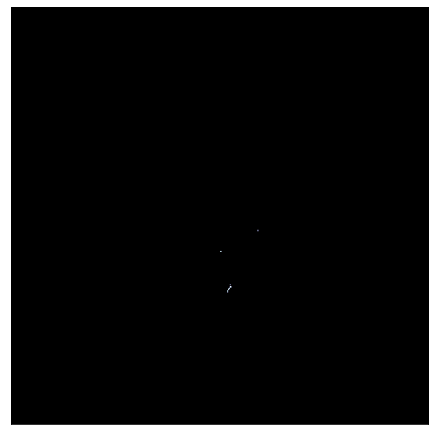

In [10]:
interact(lambda z: single_2d_plot(array_3d[z]>=1000), 
      z=IntSlider(min=0, max=array_3d.shape[0]-1, value=581, continious_update=False), 
)

## **Task 2:**
- Theory: CT with contrast allows to clearly visualize blood vessels, although sometimes they become indistinguashable from surrounding bones. 
- Given: CT scan lodaded into array_3d variable 
- Do: Apply thresholding to remove everithing, except bones. Plot the results using matplotlib. What value is best to 


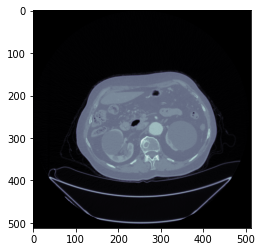

In [12]:
plt.imshow(array_3d[201], cmap='bone')

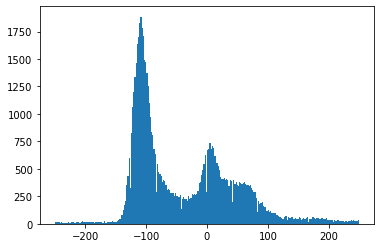

In [25]:
def f(img):
  return img 
hist = plt.hist(array_3d[201].ravel(), bins=256, range=(-250, 250))
plt.show()

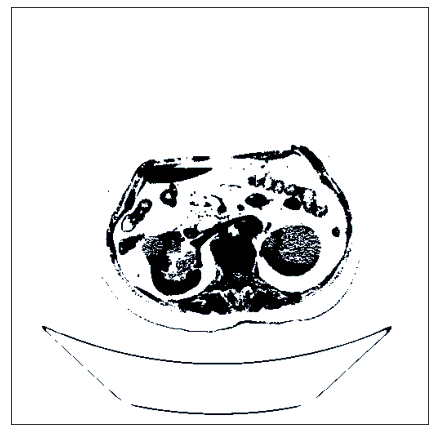

In [51]:
def thresholding(img):
  return img <= 0

interact(lambda z: single_2d_plot(thresholding(array_3d[z])), 
      z=IntSlider(min=0, max=array_3d.shape[0]-1, value=201, continious_update=False), 
)